# Readability Assessment through Learning Techniques

* Readability assessment is a well known problem in natural language processing field. 
* Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. 

In this notebook we are trying to assess the readability of a given text regardless of the text topic.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [1]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings, load_old_corpus
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

corpus = load_corpus()
articles_words, tags = corpus_to_words(corpus)
articles_pos, tags = corpus_to_pos(corpus)
old_articles_pos, old_articles_tags = load_old_corpus()

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [2]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles_words[i][:words])], 
        ["Intermediate",detokenize(articles_words[i+2][:words])], 
        ["Elementary",detokenize(articles_words[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 20px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

## Data preprocessing

### 1. Converting words to part of speech tags

In [3]:
print(articles_words[0][:10])
print(articles_pos[0][:10])

['When', 'you', 'see', 'the', 'word', 'Amazon', ',', 'whats', 'the', 'first']
['WRB', 'PRP', 'VB', 'DT', 'NN', 'NN', ',', 'VBZ', 'DT', 'JJ']


### 2. Converting part of speech to sequences

In [4]:
maxlen = 1000 # Cuts off reviews after 1000 words
max_words = 45
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles_pos)

In [5]:
sequences = tokenizer.texts_to_sequences(articles_pos)
old_sequences = tokenizer.texts_to_sequences(old_articles_pos)
print(np.shape(sequences))
print(np.shape(old_sequences))

(567,)
(183,)


### 3. Padding

In [6]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
old_data = pad_sequences(old_sequences, maxlen=maxlen, padding='post', truncating='post')
print(np.shape(data))
print(np.shape(old_data))

(567, 1000)
(183, 1000)


In [7]:
tags = np.array(tags)
old_tags = np.array(old_articles_tags)
print(tags.shape)
print(old_tags.shape)

(567,)
(183,)


### 4. Convert sequences to one hot encoding

In [8]:
data = to_categorical(data)
old_data = to_categorical(old_data)
print(data.shape)
print(old_data.shape)

(567, 1000, 45)
(183, 1000, 45)


### 5. Randomize data

In [9]:
np.random.seed(0)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
tags = tags[indices]

old_indices = np.arange(old_data.shape[0])
np.random.shuffle(indices)

old_data = old_data[old_indices]
old_tags = old_tags[old_indices]
print(data.shape)
print(tags.shape)

print(old_data.shape)
print(old_tags.shape)

(567, 1000, 45)
(567,)
(183, 1000, 45)
(183,)


## Structuring the model

In [38]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
model.add(MaxPooling1D(10))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.005, l2=0.001)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
def soft_acc(y_true, y_pred):
    from tensorflow.python.keras import backend as K
    return K.mean(K.less_equal(K.abs(y_pred-y_true),0.9))

In [39]:
es = EarlyStopping(monitor='val_soft_acc',patience=100, mode='max')
cp = ModelCheckpoint('model-{epoch:03d}-{soft_acc:03f}-{val_soft_acc:03f}.h5', verbose=0, monitor='val_soft_acc',save_best_only=True, mode='max')  
model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
history = model.fit(data, tags,epochs=750,  batch_size=50,validation_split=0.2,callbacks=[cp], verbose=1)

Train on 453 samples, validate on 114 samples
Epoch 1/750
453/453 [==============================] - 4s 9ms/step - loss: 18.8144 - soft_acc: 0.6313 - val_loss: 15.6078 - val_soft_acc: 0.5877
Epoch 2/750
453/453 [==============================] - 0s 622us/step - loss: 14.1181 - soft_acc: 0.6093 - val_loss: 12.7898 - val_soft_acc: 0.6316
Epoch 3/750
453/453 [==============================] - 0s 560us/step - loss: 11.0713 - soft_acc: 0.5850 - val_loss: 9.8092 - val_soft_acc: 0.6316
Epoch 4/750
453/453 [==============================] - 0s 625us/step - loss: 8.4728 - soft_acc: 0.6203 - val_loss: 7.4658 - val_soft_acc: 0.6754
Epoch 5/750
453/453 [==============================] - 0s 636us/step - loss: 6.3675 - soft_acc: 0.5916 - val_loss: 5.4447 - val_soft_acc: 0.6316
Epoch 6/750
453/453 [==============================] - 0s 657us/step - loss: 4.6595 - soft_acc: 0.6115 - val_loss: 4.0113 - val_soft_acc: 0.6754
Epoch 7/750
453/453 [==============================] - 0s 574us/step - loss: 3.41

Epoch 57/750
453/453 [==============================] - 0s 613us/step - loss: 0.8871 - soft_acc: 0.7660 - val_loss: 0.9411 - val_soft_acc: 0.8246
Epoch 58/750
453/453 [==============================] - 0s 549us/step - loss: 0.9058 - soft_acc: 0.7395 - val_loss: 1.0224 - val_soft_acc: 0.6579
Epoch 59/750
453/453 [==============================] - 0s 570us/step - loss: 0.9022 - soft_acc: 0.6998 - val_loss: 0.8964 - val_soft_acc: 0.8158
Epoch 60/750
453/453 [==============================] - 0s 569us/step - loss: 0.8909 - soft_acc: 0.7395 - val_loss: 0.8979 - val_soft_acc: 0.6667
Epoch 61/750
453/453 [==============================] - 0s 573us/step - loss: 0.8843 - soft_acc: 0.7020 - val_loss: 0.9630 - val_soft_acc: 0.6491
Epoch 62/750
453/453 [==============================] - 0s 579us/step - loss: 0.8904 - soft_acc: 0.7351 - val_loss: 0.9042 - val_soft_acc: 0.8246
Epoch 63/750
453/453 [==============================] - 0s 569us/step - loss: 0.8860 - soft_acc: 0.7638 - val_loss: 0.9091 -

453/453 [==============================] - 0s 562us/step - loss: 0.8339 - soft_acc: 0.7638 - val_loss: 0.8451 - val_soft_acc: 0.8158
Epoch 114/750
453/453 [==============================] - 0s 575us/step - loss: 0.8495 - soft_acc: 0.7704 - val_loss: 0.8817 - val_soft_acc: 0.8246
Epoch 115/750
453/453 [==============================] - 0s 568us/step - loss: 0.8483 - soft_acc: 0.8013 - val_loss: 0.8575 - val_soft_acc: 0.6053
Epoch 116/750
453/453 [==============================] - 0s 561us/step - loss: 0.8355 - soft_acc: 0.7417 - val_loss: 0.8564 - val_soft_acc: 0.8246
Epoch 117/750
453/453 [==============================] - 0s 553us/step - loss: 0.8444 - soft_acc: 0.7550 - val_loss: 0.8921 - val_soft_acc: 0.5877
Epoch 118/750
453/453 [==============================] - 0s 572us/step - loss: 0.8372 - soft_acc: 0.7152 - val_loss: 0.9042 - val_soft_acc: 0.8246
Epoch 119/750
453/453 [==============================] - 0s 563us/step - loss: 0.8438 - soft_acc: 0.8146 - val_loss: 0.8805 - val_so

Epoch 169/750
453/453 [==============================] - 0s 566us/step - loss: 0.7970 - soft_acc: 0.8035 - val_loss: 0.8833 - val_soft_acc: 0.5877
Epoch 170/750
453/453 [==============================] - 0s 575us/step - loss: 0.8131 - soft_acc: 0.7108 - val_loss: 0.8120 - val_soft_acc: 0.7895
Epoch 171/750
453/453 [==============================] - 0s 580us/step - loss: 0.7984 - soft_acc: 0.7638 - val_loss: 0.8529 - val_soft_acc: 0.5526
Epoch 172/750
453/453 [==============================] - 0s 576us/step - loss: 0.8017 - soft_acc: 0.7174 - val_loss: 0.8175 - val_soft_acc: 0.7105
Epoch 173/750
453/453 [==============================] - 0s 564us/step - loss: 0.7957 - soft_acc: 0.7748 - val_loss: 0.8139 - val_soft_acc: 0.7193
Epoch 174/750
453/453 [==============================] - 0s 562us/step - loss: 0.7939 - soft_acc: 0.7837 - val_loss: 0.8636 - val_soft_acc: 0.8246
Epoch 175/750
453/453 [==============================] - 0s 559us/step - loss: 0.8114 - soft_acc: 0.8102 - val_loss: 0

Epoch 225/750
453/453 [==============================] - 0s 556us/step - loss: 0.7906 - soft_acc: 0.7528 - val_loss: 0.8294 - val_soft_acc: 0.8246
Epoch 226/750
453/453 [==============================] - 0s 558us/step - loss: 0.7859 - soft_acc: 0.8146 - val_loss: 0.8284 - val_soft_acc: 0.6228
Epoch 227/750
453/453 [==============================] - 0s 563us/step - loss: 0.7858 - soft_acc: 0.7594 - val_loss: 0.8094 - val_soft_acc: 0.8158
Epoch 228/750
453/453 [==============================] - 0s 568us/step - loss: 0.7934 - soft_acc: 0.7726 - val_loss: 0.8115 - val_soft_acc: 0.6930
Epoch 229/750
453/453 [==============================] - 0s 568us/step - loss: 0.7956 - soft_acc: 0.7417 - val_loss: 0.8076 - val_soft_acc: 0.8158
Epoch 230/750
453/453 [==============================] - 0s 574us/step - loss: 0.7885 - soft_acc: 0.7837 - val_loss: 0.8160 - val_soft_acc: 0.6842
Epoch 231/750
453/453 [==============================] - 0s 571us/step - loss: 0.7865 - soft_acc: 0.7461 - val_loss: 0

Epoch 281/750
453/453 [==============================] - 0s 558us/step - loss: 0.7773 - soft_acc: 0.7528 - val_loss: 0.8444 - val_soft_acc: 0.8246
Epoch 282/750
453/453 [==============================] - 0s 574us/step - loss: 0.7848 - soft_acc: 0.7925 - val_loss: 0.8193 - val_soft_acc: 0.8246
Epoch 283/750
453/453 [==============================] - 0s 577us/step - loss: 0.7850 - soft_acc: 0.8079 - val_loss: 0.7975 - val_soft_acc: 0.7807
Epoch 284/750
453/453 [==============================] - 0s 573us/step - loss: 0.7754 - soft_acc: 0.7925 - val_loss: 0.7999 - val_soft_acc: 0.8070
Epoch 285/750
453/453 [==============================] - 0s 573us/step - loss: 0.7745 - soft_acc: 0.7815 - val_loss: 0.8201 - val_soft_acc: 0.6491
Epoch 286/750
453/453 [==============================] - 0s 574us/step - loss: 0.7778 - soft_acc: 0.7483 - val_loss: 0.8072 - val_soft_acc: 0.8158
Epoch 287/750
453/453 [==============================] - 0s 563us/step - loss: 0.7766 - soft_acc: 0.8057 - val_loss: 0

Epoch 337/750
453/453 [==============================] - 0s 554us/step - loss: 0.7667 - soft_acc: 0.7903 - val_loss: 0.8139 - val_soft_acc: 0.6667
Epoch 338/750
453/453 [==============================] - 0s 572us/step - loss: 0.7661 - soft_acc: 0.7329 - val_loss: 0.8078 - val_soft_acc: 0.8158
Epoch 339/750
453/453 [==============================] - 0s 553us/step - loss: 0.7708 - soft_acc: 0.7837 - val_loss: 0.8061 - val_soft_acc: 0.8158
Epoch 340/750
453/453 [==============================] - 0s 550us/step - loss: 0.7707 - soft_acc: 0.7748 - val_loss: 0.8372 - val_soft_acc: 0.8246
Epoch 341/750
453/453 [==============================] - 0s 556us/step - loss: 0.7829 - soft_acc: 0.8013 - val_loss: 0.7967 - val_soft_acc: 0.7895
Epoch 342/750
453/453 [==============================] - 0s 563us/step - loss: 0.7702 - soft_acc: 0.7859 - val_loss: 0.8048 - val_soft_acc: 0.8158
Epoch 343/750
453/453 [==============================] - 0s 564us/step - loss: 0.7719 - soft_acc: 0.7925 - val_loss: 0

Epoch 393/750
453/453 [==============================] - 0s 567us/step - loss: 0.7616 - soft_acc: 0.7969 - val_loss: 0.8037 - val_soft_acc: 0.7018
Epoch 394/750
453/453 [==============================] - 0s 567us/step - loss: 0.7621 - soft_acc: 0.7506 - val_loss: 0.7949 - val_soft_acc: 0.7281
Epoch 395/750
453/453 [==============================] - 0s 561us/step - loss: 0.7598 - soft_acc: 0.7660 - val_loss: 0.7904 - val_soft_acc: 0.7456
Epoch 396/750
453/453 [==============================] - 0s 557us/step - loss: 0.7622 - soft_acc: 0.7815 - val_loss: 0.7872 - val_soft_acc: 0.7544
Epoch 397/750
453/453 [==============================] - 0s 567us/step - loss: 0.7567 - soft_acc: 0.8035 - val_loss: 0.8564 - val_soft_acc: 0.5965
Epoch 398/750
453/453 [==============================] - 0s 563us/step - loss: 0.7728 - soft_acc: 0.7307 - val_loss: 0.7850 - val_soft_acc: 0.7456
Epoch 399/750
453/453 [==============================] - 0s 570us/step - loss: 0.7558 - soft_acc: 0.7969 - val_loss: 0

Epoch 449/750
453/453 [==============================] - 0s 564us/step - loss: 0.7518 - soft_acc: 0.7881 - val_loss: 0.7816 - val_soft_acc: 0.7544
Epoch 450/750
453/453 [==============================] - 0s 573us/step - loss: 0.7506 - soft_acc: 0.7726 - val_loss: 0.7881 - val_soft_acc: 0.7368
Epoch 451/750
453/453 [==============================] - 0s 556us/step - loss: 0.7483 - soft_acc: 0.7726 - val_loss: 0.7822 - val_soft_acc: 0.7632
Epoch 452/750
453/453 [==============================] - 0s 556us/step - loss: 0.7487 - soft_acc: 0.7770 - val_loss: 0.8150 - val_soft_acc: 0.8158
Epoch 453/750
453/453 [==============================] - 0s 558us/step - loss: 0.7574 - soft_acc: 0.7925 - val_loss: 0.8139 - val_soft_acc: 0.8158
Epoch 454/750
453/453 [==============================] - 0s 565us/step - loss: 0.7530 - soft_acc: 0.8124 - val_loss: 0.8151 - val_soft_acc: 0.6842
Epoch 455/750
453/453 [==============================] - 0s 574us/step - loss: 0.7525 - soft_acc: 0.7550 - val_loss: 0

Epoch 505/750
453/453 [==============================] - 0s 566us/step - loss: 0.7412 - soft_acc: 0.7903 - val_loss: 0.7925 - val_soft_acc: 0.8070
Epoch 506/750
453/453 [==============================] - 0s 563us/step - loss: 0.7462 - soft_acc: 0.7925 - val_loss: 0.7884 - val_soft_acc: 0.7368
Epoch 507/750
453/453 [==============================] - 0s 571us/step - loss: 0.7447 - soft_acc: 0.7748 - val_loss: 0.7788 - val_soft_acc: 0.7807
Epoch 508/750
453/453 [==============================] - 0s 572us/step - loss: 0.7439 - soft_acc: 0.7792 - val_loss: 0.8030 - val_soft_acc: 0.7105
Epoch 509/750
453/453 [==============================] - 0s 568us/step - loss: 0.7404 - soft_acc: 0.7616 - val_loss: 0.7804 - val_soft_acc: 0.7719
Epoch 510/750
453/453 [==============================] - 0s 565us/step - loss: 0.7402 - soft_acc: 0.7969 - val_loss: 0.8040 - val_soft_acc: 0.7105
Epoch 511/750
453/453 [==============================] - 0s 575us/step - loss: 0.7422 - soft_acc: 0.7859 - val_loss: 0

Epoch 561/750
453/453 [==============================] - 0s 554us/step - loss: 0.7439 - soft_acc: 0.7991 - val_loss: 0.7780 - val_soft_acc: 0.7807
Epoch 562/750
453/453 [==============================] - 0s 573us/step - loss: 0.7375 - soft_acc: 0.7947 - val_loss: 0.8009 - val_soft_acc: 0.8070
Epoch 563/750
453/453 [==============================] - 0s 563us/step - loss: 0.7468 - soft_acc: 0.8035 - val_loss: 0.7914 - val_soft_acc: 0.7895
Epoch 564/750
453/453 [==============================] - 0s 569us/step - loss: 0.7399 - soft_acc: 0.8102 - val_loss: 0.7797 - val_soft_acc: 0.7807
Epoch 565/750
453/453 [==============================] - 0s 570us/step - loss: 0.7396 - soft_acc: 0.7947 - val_loss: 0.7862 - val_soft_acc: 0.7456
Epoch 566/750
453/453 [==============================] - 0s 570us/step - loss: 0.7371 - soft_acc: 0.7859 - val_loss: 0.7938 - val_soft_acc: 0.7281
Epoch 567/750
453/453 [==============================] - 0s 568us/step - loss: 0.7409 - soft_acc: 0.7748 - val_loss: 0

Epoch 617/750
453/453 [==============================] - 0s 562us/step - loss: 0.7382 - soft_acc: 0.8057 - val_loss: 0.7830 - val_soft_acc: 0.7982
Epoch 618/750
453/453 [==============================] - 0s 585us/step - loss: 0.7363 - soft_acc: 0.8079 - val_loss: 0.7781 - val_soft_acc: 0.7807
Epoch 619/750
453/453 [==============================] - 0s 557us/step - loss: 0.7359 - soft_acc: 0.7881 - val_loss: 0.7843 - val_soft_acc: 0.7544
Epoch 620/750
453/453 [==============================] - 0s 557us/step - loss: 0.7327 - soft_acc: 0.7748 - val_loss: 0.7869 - val_soft_acc: 0.7895
Epoch 621/750
453/453 [==============================] - 0s 570us/step - loss: 0.7382 - soft_acc: 0.8013 - val_loss: 0.7877 - val_soft_acc: 0.7456
Epoch 622/750
453/453 [==============================] - 0s 581us/step - loss: 0.7326 - soft_acc: 0.7815 - val_loss: 0.8264 - val_soft_acc: 0.6842
Epoch 623/750
453/453 [==============================] - 0s 564us/step - loss: 0.7425 - soft_acc: 0.7506 - val_loss: 0

Epoch 673/750
453/453 [==============================] - 0s 568us/step - loss: 0.7310 - soft_acc: 0.8035 - val_loss: 0.8111 - val_soft_acc: 0.7105
Epoch 674/750
453/453 [==============================] - 0s 569us/step - loss: 0.7346 - soft_acc: 0.7903 - val_loss: 0.8189 - val_soft_acc: 0.7105
Epoch 675/750
453/453 [==============================] - 0s 575us/step - loss: 0.7359 - soft_acc: 0.7726 - val_loss: 0.7982 - val_soft_acc: 0.7193
Epoch 676/750
453/453 [==============================] - 0s 570us/step - loss: 0.7331 - soft_acc: 0.7837 - val_loss: 0.7830 - val_soft_acc: 0.7982
Epoch 677/750
453/453 [==============================] - 0s 566us/step - loss: 0.7330 - soft_acc: 0.7969 - val_loss: 0.7908 - val_soft_acc: 0.7719
Epoch 678/750
453/453 [==============================] - 0s 565us/step - loss: 0.7328 - soft_acc: 0.8035 - val_loss: 0.8019 - val_soft_acc: 0.7193
Epoch 679/750
453/453 [==============================] - 0s 568us/step - loss: 0.7304 - soft_acc: 0.7859 - val_loss: 0

Epoch 729/750
453/453 [==============================] - 0s 578us/step - loss: 0.7278 - soft_acc: 0.7969 - val_loss: 0.8193 - val_soft_acc: 0.6930
Epoch 730/750
453/453 [==============================] - 0s 574us/step - loss: 0.7334 - soft_acc: 0.7815 - val_loss: 0.7910 - val_soft_acc: 0.7368
Epoch 731/750
453/453 [==============================] - 0s 582us/step - loss: 0.7251 - soft_acc: 0.7969 - val_loss: 0.7812 - val_soft_acc: 0.8158
Epoch 732/750
453/453 [==============================] - 0s 599us/step - loss: 0.7255 - soft_acc: 0.8168 - val_loss: 0.7808 - val_soft_acc: 0.8070
Epoch 733/750
453/453 [==============================] - 0s 584us/step - loss: 0.7236 - soft_acc: 0.8102 - val_loss: 0.7816 - val_soft_acc: 0.8158
Epoch 734/750
453/453 [==============================] - 0s 591us/step - loss: 0.7270 - soft_acc: 0.8079 - val_loss: 0.8039 - val_soft_acc: 0.7105
Epoch 735/750
453/453 [==============================] - 0s 595us/step - loss: 0.7321 - soft_acc: 0.7991 - val_loss: 0

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 996, 128)          28928     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 99, 128)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 95, 64)            41024     
_________________________________________________________________
global_max_pooling1d_29 (Glo (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 70,017
Trainable params: 70,017
Non-trainable params: 0
_________________________________________________________________


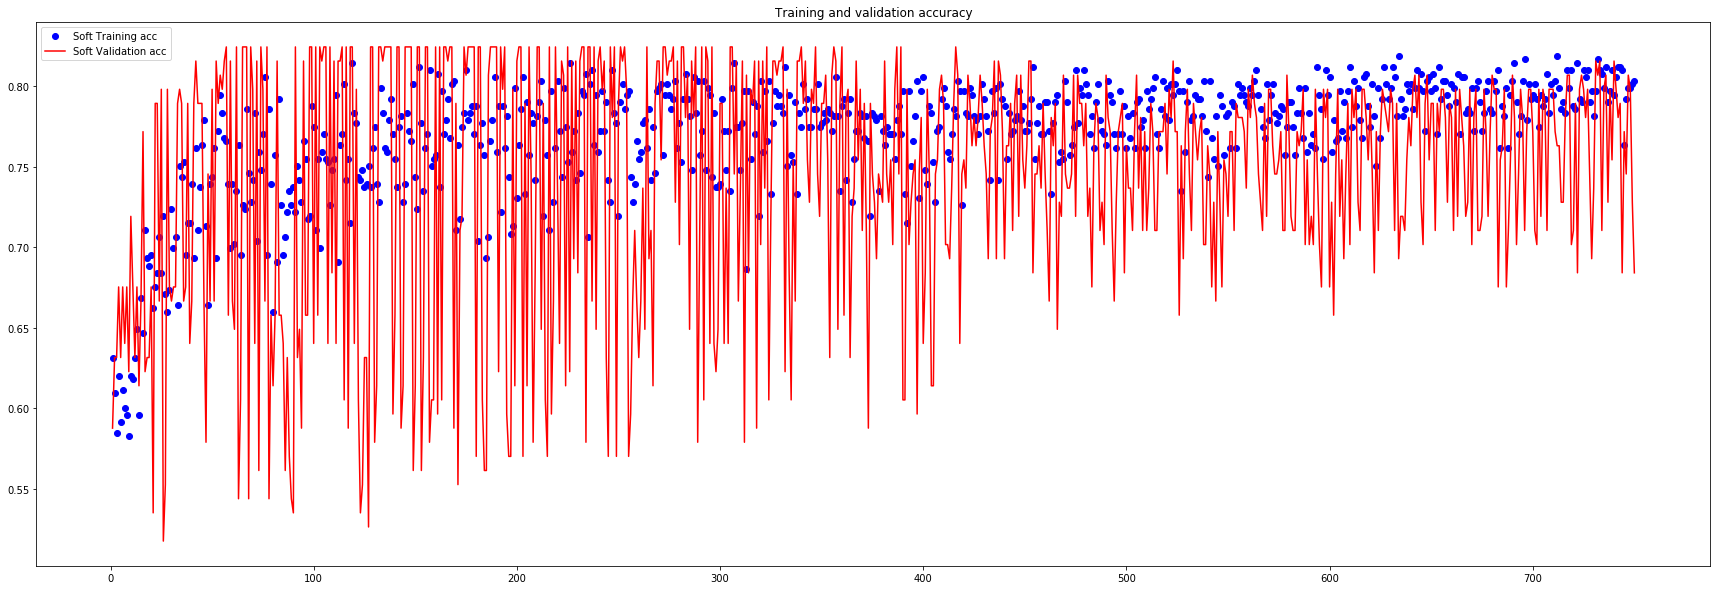

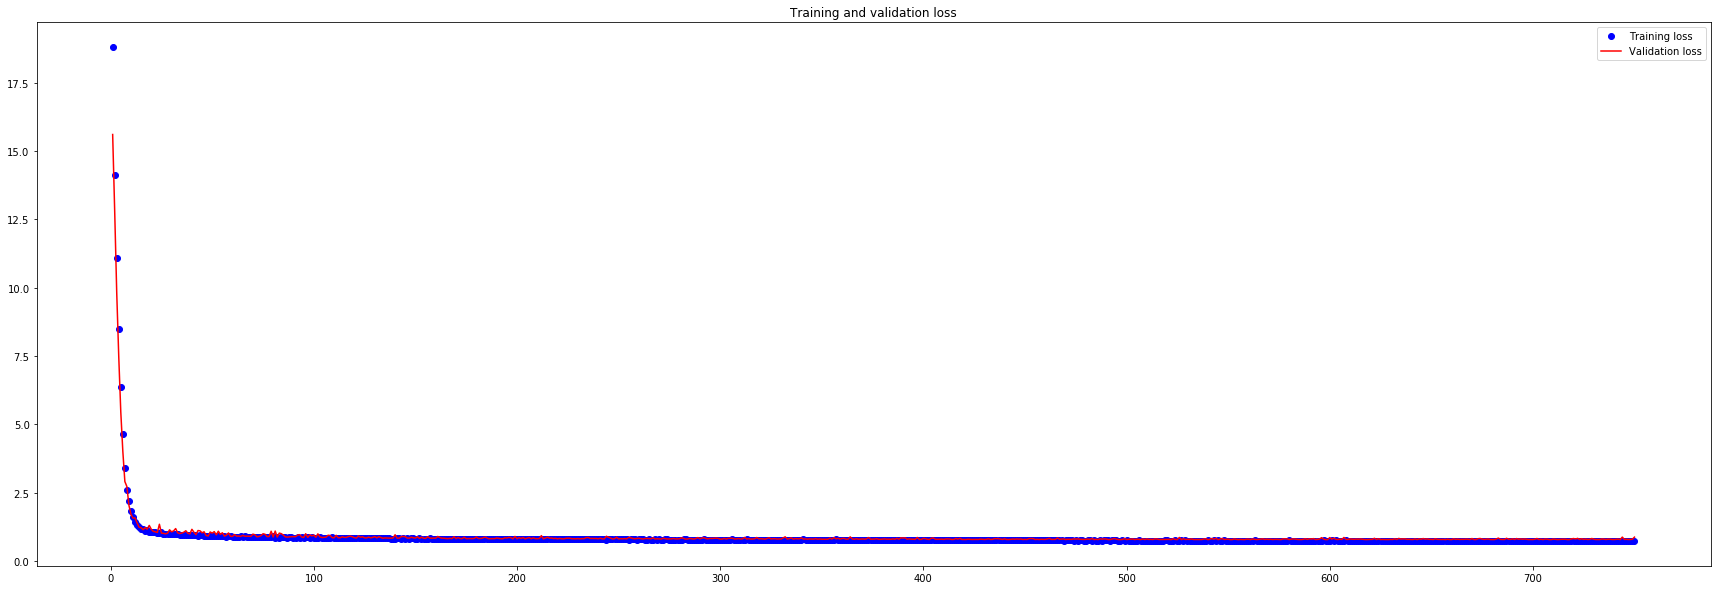

In [41]:
import matplotlib.pyplot as plt

soft_acc = history.history['soft_acc']
soft_val_acc = history.history['val_soft_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(soft_acc) + 1)
plt.figure(figsize=(30,10))
plt.plot(epochs, soft_acc, 'bo', label='Soft Training acc')
plt.plot(epochs, soft_val_acc, 'r', label='Soft Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(30,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()




### Evaluation on old dataset

In [42]:
print(model.evaluate(old_data, old_tags))
print(model.metrics_names)

183/183 [==============================] - 0s 319us/step
[0.9068193448697283, 0.7103825104041178]
['loss', 'soft_acc']


### 10 Fold Validation

In [43]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvs_scores = []
for train, test in kfold.split(data, tags):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.005, l2=0.005)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1))
    def soft_acc(y_true, y_pred):
        from tensorflow.python.keras import backend as K
        return K.mean(K.less_equal(K.abs(y_pred-y_true),0.9))
    model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
    model.fit(data[train], tags[train], epochs=750, verbose=0)
    scores = model.evaluate(data[test], tags[test], verbose=0)
    print(scores[1]*100)
    cvs_scores.append(scores[1]*100)
print("Accuracy:", np.mean(cvs_scores),"std:", np.std(cvs_scores))

78.9473689439004
78.94736967588726
85.96491113043669
85.96491207156265
80.70175564079955
85.96491207156265
80.70175323569984
80.70175490881267
89.47368326940035
85.18518496442724
Accuracy: 83.25536059124893 std: 3.479900144047049
